In [84]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
import gzip
from Bio import SeqIO
import itertools
from Bio.Seq import Seq

### Calculation the average length of the enhancer

In [27]:
df_positive = pd.read_csv('GM12878.bed', header=None, sep="\t")

In [28]:
def preprocess_sets(df, label):
    df.rename(columns ={df.columns[0] : "ID", df.columns[1]: 'first', df.columns[2] :'last'}, inplace=True)
    df = df.loc[~df.ID.isin(['chrM', 'chrX', 'chrY'])].copy()
    df['label'] = label
    return df

In [29]:
df_positive = preprocess_sets(df_positive, True)
df_positive.drop(df_positive.columns[3], axis = 1, inplace=True)
df_positive['length'] = df_positive['last']-df_positive['first']+1
df_positive

,ID,first,last,label,length
0,chr1,773300,774100,True,801
1,chr1,778980,779450,True,471
2,chr1,800100,802000,True,1901
3,chr1,825670,826410,True,741
4,chr1,839470,842590,True,3121
...,...,...,...,...,...
48555,chr9,140651150,140652330,True,1181
48556,chr9,140702130,140703100,True,971
48557,chr9,140703310,140704120,True,811
48558,chr9,140710520,140711890,True,1371


In [30]:
df_positive.loc[:, 'length'].mean()

1745.0801070840198

#### The average length rounded to 100 is 1700

In [31]:
mean_val  = 1700

### Wyznaczenie predykcji dla każdego okna

In [36]:
# Fasta file
df_fasta = pd.DataFrame(columns=['ID', 'sequence'])
with gzip.open("GRCh37.primary_assembly.genome.fa.gz", "rt") as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        identifier = record.id
        sequence = record.seq
        df_fasta = pd.concat([df_fasta, pd.DataFrame.from_records([{'ID':identifier, 'sequence':sequence}])], ignore_index=True)
df_fasta.drop(df_fasta[(df_fasta.ID.str.startswith('GL')) | (df_fasta.ID.isin(['chrM', 'chrX', 'chrY'])) ].index, inplace=True)
df_fasta.set_index('ID', inplace=True)

In [37]:
df_fasta

,sequence
ID,
chr1,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr10,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr11,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr12,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr13,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr14,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr15,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr16,"(N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
chr17,"(A, A, G, C, T, T, C, T, C, A, C, C, C, T, G, ..."


In [38]:
df_fasta.loc['chr9', 'sequence']

Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')

In [39]:
df_train = pd.read_csv('df_train_4mers.csv', index_col=0)
df_test = pd.read_csv('df_test_4mers.csv', index_col=0)

In [40]:
X_test = df_test.loc[:, df_test.columns != 'label'].copy()
y_test = df_test['label'].to_numpy()

X_train = df_train.loc[:, df_train.columns != 'label'].copy()
y_train = df_train['label'].to_numpy()

In [41]:
model_abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=4),n_estimators=200,learning_rate=0.2)

In [42]:
model_abc.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_split=4),
                   learning_rate=0.2, n_estimators=200)

In [44]:
model_rf = RandomForestClassifier(n_estimators=300,max_depth=3)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=300)

### Preparing function for data transformation

In [75]:
def get_unique_kmers(k):
    letters = ["C", "A", "T", "G"]
    combinations_str = [''.join(i) for i in itertools.product(letters, repeat = k)]
    combinations = [Seq(mer) for mer in combinations_str]
    unique_kmers = []
    [unique_kmers.append(x) for x in combinations if x not in unique_kmers and x.reverse_complement() not in unique_kmers]
    unique_kmers = dict.fromkeys(unique_kmers, 0)
    return unique_kmers

In [85]:
unique_kmers = get_unique_kmers(4)

In [76]:
def replace_with_mean(x):
    k=0
    m=0
    for i in x:
        if i >= 0 :
            k+=i
            m+=1
    mean = k/m        
    for i in range(len(x)):
        if x[i] == -1:
            x[i] = mean
    return x

In [77]:
def count_prediction(model, sequence, unique_kmers, k):
    prob = []
    l = len(sequence)
    p = l // 1700
    for i in range(p+1):
        frequency = []    
        if i == p : 
            seq = sequence[p*1700 : l]
        else:
            seq = sequence[i*1700 : (i*1700 + 1700)]
        if seq.count("N")/len(seq) < 0.05:
        
            kmers_in_seq = len(seq) - k + 1

            for kmer in unique_kmers:
                kmer_rc = kmer.reverse_complement()
                if str(kmer) == str(kmer_rc):
                    count = seq.count_overlap(kmer)
                else:
                    count = seq.count_overlap(kmer) + seq.count_overlap(kmer_rc)
                frequency.append(count / kmers_in_seq) 
            ff = [frequency]
            prob.append(model.predict_proba(ff)[0,1])
        else :
            prob.append(-1)
    prob = replace_with_mean(prob)
    return prob         

### Zapisywanie i ładowanie listy

In [102]:
np.save("chr1", prob1)

In [ ]:
tempNumpyArray=np.load("prob1.npy")
tempNumpyArray.tolist()

Despite of the fact the AdaBoost model has a little bit better scores (both accurasy and precision) we have decided to use RandomForest because AdaBoost almost always predict around 48% - 51% chance to be an enhancer witch can be seen on the belowes plot

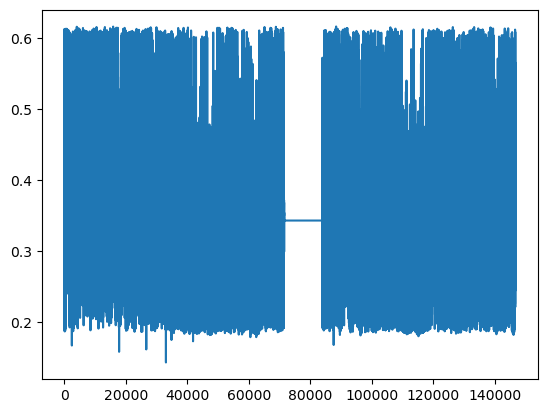

In [89]:
from matplotlib import pyplot as plt
plt.plot(prob1)

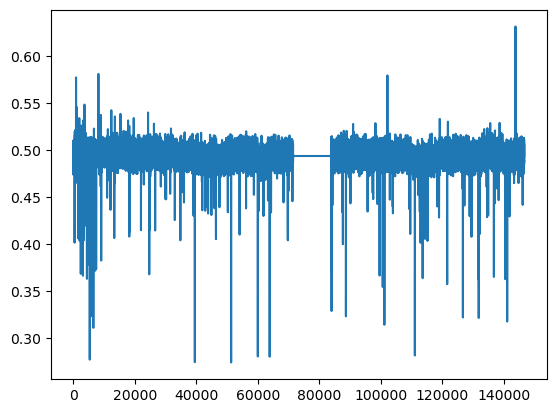

In [90]:
import warnings
warnings.filterwarnings('ignore')
prob12 = count_prediction(model_abc, chr1, unique_kmers, 4)
plt.plot(prob12)

In [248]:
prob9

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0.5122957169624981,
 0.4979624335554668,
 0.5003359092064424,
 0.5025803870357933,
 0.4888541718438137,
 0.4987451764748878,
 0.5029076097008081,
 0.4968932988999344,
 0.4968917748453322,
 0.5000480107935777,
 0.49783639920370937,
 0.5097330464441894,
 0.49784762453272163,
 0.4923924345257035,
 0.4973251934599036,
 0.49793774473753716,
 0.5045117281587846,
 0.4959297559698436,
 0.4933349091790065,
 0.4870985372459257,
 0.49914785694694974,
 0.49885339864486494,
 0.490123957663304,
 0.4891761836582026,
 0.4828389074254965,
 0.49689275177971837,
 0.4862515438655768,
 0.48956419343868013,
 0.498402141192261,
 0.49508442857623797,
 0.4884190376402502,
 0.49373316531893147,
 0.49299476935406045,
 0.4995767755449956,
 0.4964845888423851,
 0.48748848434119124,
 0.5026901421553518,
 0.5020732112507966,
 0.4985452997730561,
 0.4896131648767522,
 0.4914519585208764,
 0.48741653466484747,
 0.49921801200158944,
 0.49344381172495344,
 0.48977330789418455,
 0.500549459

### Preparing and saving the data
Calculating the prediction for each window of 1700 nucleotides in each chromosom.

In [124]:
list = ['chr1','chr2', 'chr3', 'chr4', 'chr5', 'chr6','chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12','chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']

In [104]:
warnings.filterwarnings('ignore')
for x in list:
    chrr = df_fasta.loc[x, 'sequence']
    prob = count_prediction(model_rf, chrr, unique_kmers, 4)
    np.save(x, prob)
    print(f"plik: {x} został zapisany")

plik: chr2 został zapisany
plik: chr3 został zapisany
plik: chr4 został zapisany
plik: chr5 został zapisany
plik: chr6 został zapisany
plik: chr7 został zapisany
plik: chr8 został zapisany
plik: chr9 został zapisany
plik: chr10 został zapisany
plik: chr11 został zapisany
plik: chr12 został zapisany
plik: chr13 został zapisany
plik: chr14 został zapisany
plik: chr15 został zapisany
plik: chr16 został zapisany
plik: chr17 został zapisany
plik: chr18 został zapisany
plik: chr19 został zapisany
plik: chr20 został zapisany
plik: chr21 został zapisany
plik: chr22 został zapisany


'chr1' isnt here, because i saved it before

#### Data loading
function that returns a list for each chromosome (e.g. chr1, chr2 ...)

In [122]:
tab_of_chromosoms = []
for x in list:
    exec(f"{x} = np.load(x+'.npy').tolist()")